In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, f1_score, accuracy_score, precision_score, recall_score
)
from keras.models import Model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Construir ruta al archivo de datos
ruta_datos = os.path.join(os.getcwd(), "data", "data", "application_train.csv")
if not os.path.exists(ruta_datos):
    ruta_datos = os.path.join(os.getcwd(), "..", "..", "data", "data", "application_train.csv")
datos = pd.read_csv(ruta_datos)

filas, columnas = datos.shape
tasa_incumplimiento = datos["TARGET"].mean() * 100
casos_normales = (datos["TARGET"] == 0).sum()
casos_incumplidos = (datos["TARGET"] == 1).sum()

print(f"\nArchivo cargado correctamente: {filas} filas y {columnas} columnas")
print(f"Tasa de incumplimiento: {tasa_incumplimiento:.2f}%")
print(f"Casos normales: {casos_normales} | Casos incumplidos: {casos_incumplidos}")


Archivo cargado correctamente: 307511 filas y 122 columnas
Tasa de incumplimiento: 8.07%
Casos normales: 282686 | Casos incumplidos: 24825


In [2]:
# CREACION DE VARIABLES NUMERICAS

# Variables de tiempo
datos['EDAD'] = -datos['DAYS_BIRTH'] / 365
datos['AÑOS_EMPLEADO'] = -datos['DAYS_EMPLOYED'] / 365
datos['AÑOS_EMPLEADO'] = datos['AÑOS_EMPLEADO'].replace(1000.67, np.nan)
datos['DIAS_CAMBIO_TELEFONO'] = -datos['DAYS_LAST_PHONE_CHANGE']
datos['DIAS_PUBLICACION_ID'] = -datos['DAYS_ID_PUBLISH']

# Ratios financieros
datos['RATIO_CREDITO_INGRESO'] = datos['AMT_CREDIT'] / datos['AMT_INCOME_TOTAL']
datos['RATIO_ANUALIDAD_INGRESO'] = datos['AMT_ANNUITY'] / datos['AMT_INCOME_TOTAL']
datos['RATIO_ANUALIDAD_CREDITO'] = datos['AMT_ANNUITY'] / datos['AMT_CREDIT']
datos['RATIO_BIENES_CREDITO'] = datos['AMT_GOODS_PRICE'] / datos['AMT_CREDIT']
datos['INGRESO_PER_CAPITA'] = datos['AMT_INCOME_TOTAL'] / (datos['CNT_FAM_MEMBERS'] + 1)
datos['CREDITO_PER_CAPITA'] = datos['AMT_CREDIT'] / (datos['CNT_FAM_MEMBERS'] + 1)

# Detección de inconsistencias
datos['INCONS_SCORE_INGRESO'] = 0
mask1 = (datos['EXT_SOURCE_2'] < 0.3) & (datos['AMT_INCOME_TOTAL'] > datos['AMT_INCOME_TOTAL'].quantile(0.75))
datos.loc[mask1, 'INCONS_SCORE_INGRESO'] = 1

datos['INCONS_FAMILIA_INGRESO'] = 0
mask2 = (datos['CNT_FAM_MEMBERS'] >= 4) & (datos['AMT_INCOME_TOTAL'] < datos['AMT_INCOME_TOTAL'].quantile(0.25))
datos.loc[mask2, 'INCONS_FAMILIA_INGRESO'] = 1

columnas_docs = [col for col in datos.columns if 'FLAG_DOCUMENT' in col]
datos['TOTAL_DOCUMENTOS'] = datos[columnas_docs].sum(axis=1)
datos['INCONS_DOCS_CREDITO'] = 0
mask3 = (datos['TOTAL_DOCUMENTOS'] <= 2) & (datos['AMT_CREDIT'] > datos['AMT_CREDIT'].quantile(0.75))
datos.loc[mask3, 'INCONS_DOCS_CREDITO'] = 1

datos['TOTAL_INCONSISTENCIAS'] = (datos['INCONS_SCORE_INGRESO'] + 
                                   datos['INCONS_FAMILIA_INGRESO'] + 
                                   datos['INCONS_DOCS_CREDITO'])

# Variables de círculo social
datos['DEFAULTS_SOCIALES'] = (datos['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(0) + 
                               datos['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(0))
datos['OBSERVACIONES_SOCIALES'] = (datos['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(0) + 
                                    datos['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(0))
datos['TASA_DEFAULT_SOCIAL'] = datos['DEFAULTS_SOCIALES'] / (datos['OBSERVACIONES_SOCIALES'] + 1)
datos['TIENE_CIRCULO_RIESGOSO'] = (datos['DEFAULTS_SOCIALES'] > 0).astype(int)

# Variables de estabilidad
datos['TIENE_AUTO'] = (~datos['OWN_CAR_AGE'].isna()).astype(int)
datos['TIENE_PROPIEDAD'] = (datos['FLAG_OWN_REALTY'] == 'Y').astype(int)
datos['CAMBIO_TELEFONO_RECIENTE'] = (datos['DIAS_CAMBIO_TELEFONO'] < 180).astype(int)
datos['PUBLICACION_ID_RECIENTE'] = (datos['DIAS_PUBLICACION_ID'] < 365).astype(int)

datos['SCORE_ESTABILIDAD'] = (datos['TIENE_AUTO'] + datos['TIENE_PROPIEDAD'] + 
                               (1 - datos['CAMBIO_TELEFONO_RECIENTE']) + 
                               (1 - datos['PUBLICACION_ID_RECIENTE']))

# Interacciones y flags de riesgo
datos['RATIO_EDAD_EMPLEO'] = datos['EDAD'] / (datos['AÑOS_EMPLEADO'] + 1)
datos['SOBREENDEUDAMIENTO'] = (datos['RATIO_CREDITO_INGRESO'] > 8).astype(int)
datos['JOVEN_CREDITO_ALTO'] = ((datos['EDAD'] < 25) & (datos['AMT_CREDIT'] > 500000)).astype(int)
datos['EMPLEO_NUEVO_CREDITO_ALTO'] = ((datos['AÑOS_EMPLEADO'] < 0.5) & (datos['AMT_CREDIT'] > 300000)).astype(int)

columnas_bureau = [col for col in datos.columns if 'AMT_REQ_CREDIT_BUREAU' in col]
datos['TOTAL_CONSULTAS_BUREAU'] = datos[columnas_bureau].sum(axis=1)
datos['CONSULTAS_EXCESIVAS'] = (datos['TOTAL_CONSULTAS_BUREAU'] > 5).astype(int)

print(f"\nVariables numéricas creadas exitosamente")
print(f"Inconsistencias detectadas: {datos['TOTAL_INCONSISTENCIAS'].sum()}")


Variables numéricas creadas exitosamente
Inconsistencias detectadas: 89958


In [3]:
# SELECCION Y CODIFICACION DE VARIABLES CATEGORICAS

# Variables categóricas a incluir
variables_categoricas = [
    'NAME_CONTRACT_TYPE',      # Tipo de contrato (Cash/Revolving)
    'CODE_GENDER',             # Género
    'NAME_TYPE_SUITE',         # Con quién vino a la solicitud
    'NAME_INCOME_TYPE',        # Tipo de ingreso
    'NAME_EDUCATION_TYPE',     # Nivel educativo
    'NAME_FAMILY_STATUS',      # Estado civil
    'NAME_HOUSING_TYPE',       # Tipo de vivienda
    'OCCUPATION_TYPE',         # Profesión
    'WEEKDAY_APPR_PROCESS_START', # Día de la semana de solicitud
    'ORGANIZATION_TYPE',       # Tipo de organización
    'FONDKAPREMONT_MODE',      # Tipo de renovación de apartamento
    'HOUSETYPE_MODE',          # Tipo de casa
    'WALLSMATERIAL_MODE'       # Material de paredes
]

# Imputar valores nulos en categóricas con 'Unknown'
for col in variables_categoricas:
    if col in datos.columns:
        datos[col] = datos[col].fillna('Unknown')

# Aplicar One-Hot Encoding
print("\nAplicando One-Hot Encoding...")
datos_encoded = pd.get_dummies(datos, columns=variables_categoricas, drop_first=True)

# Obtener las columnas generadas por One-Hot Encoding
columnas_categoricas_encoded = [col for col in datos_encoded.columns 
                                 if any(cat in col for cat in variables_categoricas)]

print(f"Variables categóricas originales: {len(variables_categoricas)}")
print(f"Variables generadas por One-Hot Encoding: {len(columnas_categoricas_encoded)}")

# Mostrar algunas columnas generadas
print(f"\nEjemplos de columnas categóricas codificadas:")
for col in columnas_categoricas_encoded[:10]:
    print(f"  - {col}")


Aplicando One-Hot Encoding...
Variables categóricas originales: 13
Variables generadas por One-Hot Encoding: 126

Ejemplos de columnas categóricas codificadas:
  - NAME_CONTRACT_TYPE_Revolving loans
  - CODE_GENDER_M
  - CODE_GENDER_XNA
  - NAME_TYPE_SUITE_Family
  - NAME_TYPE_SUITE_Group of people
  - NAME_TYPE_SUITE_Other_A
  - NAME_TYPE_SUITE_Other_B
  - NAME_TYPE_SUITE_Spouse, partner
  - NAME_TYPE_SUITE_Unaccompanied
  - NAME_TYPE_SUITE_Unknown


In [4]:
# PREPARACION DEL DATASET FINAL

# Variables numéricas (del modelo original)
variables_numericas = [
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
    'RATIO_CREDITO_INGRESO', 'RATIO_ANUALIDAD_INGRESO', 'RATIO_ANUALIDAD_CREDITO',
    'INGRESO_PER_CAPITA', 'CREDITO_PER_CAPITA',
    'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'EDAD', 'AÑOS_EMPLEADO', 'DAYS_REGISTRATION', 'RATIO_EDAD_EMPLEO',
    'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'TASA_DEFAULT_SOCIAL', 'TIENE_CIRCULO_RIESGOSO',
    'REGION_RATING_CLIENT', 'REG_CITY_NOT_WORK_CITY',
    'TOTAL_DOCUMENTOS', 'SCORE_ESTABILIDAD',
    'TOTAL_INCONSISTENCIAS', 'INCONS_SCORE_INGRESO', 
    'INCONS_FAMILIA_INGRESO', 'INCONS_DOCS_CREDITO',
    'SOBREENDEUDAMIENTO', 'JOVEN_CREDITO_ALTO', 'EMPLEO_NUEVO_CREDITO_ALTO', 
    'CONSULTAS_EXCESIVAS', 'CAMBIO_TELEFONO_RECIENTE'
]

# Combinar variables numéricas y categóricas
variables_finales = variables_numericas + columnas_categoricas_encoded

# Crear dataset de trabajo
datos_trabajo = datos_encoded[variables_finales + ['TARGET', 'SK_ID_CURR']].copy()

# Imputar valores nulos en numéricas
for col in variables_numericas:
    if datos_trabajo[col].isnull().sum() > 0:
        if col in ['EXT_SOURCE_2', 'EXT_SOURCE_3']:
            datos_trabajo[col].fillna(datos_trabajo[col].median(), inplace=True)
        else:
            datos_trabajo[col].fillna(0, inplace=True)

# Las categóricas codificadas ya son 0/1, no necesitan imputación

print(f"\nDataset preparado:")
print(f"Total de variables: {len(variables_finales)}")
print(f"  - Numéricas: {len(variables_numericas)}")
print(f"  - Categóricas (One-Hot): {len(columnas_categoricas_encoded)}")
print(f"Total de registros: {datos_trabajo.shape[0]:,}")


Dataset preparado:
Total de variables: 157
  - Numéricas: 31
  - Categóricas (One-Hot): 126
Total de registros: 307,511


In [5]:
# SEPARACION Y ESCALADO DE DATOS

# Separar datos normales para entrenar el autoencoder (solo con TARGET=0)
datos_normales = datos_trabajo[datos_trabajo['TARGET'] == 0].copy()
X_normales = datos_normales[variables_finales].values
X_todos = datos_trabajo[variables_finales].values
y_todos = datos_trabajo['TARGET'].values

# Dividir datos normales en entrenamiento y validación
X_entrenamiento, X_validacion = train_test_split(X_normales, test_size=0.2, random_state=42)

# Escalar datos con RobustScaler (robusto a outliers)
escalador = RobustScaler()
X_entrenamiento_escalado = escalador.fit_transform(X_entrenamiento)
X_validacion_escalado = escalador.transform(X_validacion)
X_todos_escalado = escalador.transform(X_todos)

print(f"\nDatos preparados para entrenamiento:")
print(f"Entrenamiento: {X_entrenamiento.shape}")
print(f"Validación: {X_validacion.shape}")
print(f"Dataset completo: {X_todos.shape}")
print(f"\nDistribución TARGET:")
print(f"  Normal (0): {(y_todos == 0).sum():,} ({(y_todos == 0).mean()*100:.2f}%)")
print(f"  Fraude (1): {(y_todos == 1).sum():,} ({(y_todos == 1).mean()*100:.2f}%)")


Datos preparados para entrenamiento:
Entrenamiento: (226148, 157)
Validación: (56538, 157)
Dataset completo: (307511, 157)

Distribución TARGET:
  Normal (0): 282,686 (91.93%)
  Fraude (1): 24,825 (8.07%)


In [6]:
# CONSTRUCCION Y ENTRENAMIENTO DEL AUTOENCODER

# Definir arquitectura del autoencoder (más profunda por más variables)
dimension_entrada = X_entrenamiento_escalado.shape[1]

print(f"\nConstruyendo autoencoder con {dimension_entrada} variables de entrada...")

# Capa de entrada
entrada = Input(shape=(dimension_entrada,))

# Encoder: comprime la información (arquitectura más grande)
x = Dense(256, activation='relu')(entrada)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Capa latente (representación comprimida)
codigo = Dense(32, activation='relu')(x)

# Decoder: reconstruye la información
x = Dense(64, activation='relu')(codigo)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

# Capa de salida
salida = Dense(dimension_entrada, activation='linear')(x)

# Crear y compilar el modelo
autoencoder = Model(entrada, salida)
autoencoder.compile(optimizer='adam', loss='mae', metrics=['mse'])

print(f"\nModelo creado exitosamente")
autoencoder.summary()

# Configurar callbacks para el entrenamiento
parada_temprana = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True, 
    verbose=1
)

reducir_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=7, 
    verbose=1, 
    min_lr=1e-7
)

# Entrenar el modelo
print("\n" + "="*80)
print("INICIANDO ENTRENAMIENTO DEL AUTOENCODER")
print("="*80)

historial = autoencoder.fit(
    X_entrenamiento_escalado, X_entrenamiento_escalado,
    epochs=150,
    batch_size=256,
    validation_data=(X_validacion_escalado, X_validacion_escalado),
    callbacks=[parada_temprana, reducir_lr],
    verbose=1
)

print(f"\n" + "="*80)
print(f"ENTRENAMIENTO COMPLETADO")
print("="*80)
print(f"Épocas entrenadas: {len(historial.history['loss'])}")
print(f"Loss final entrenamiento: {historial.history['loss'][-1]:.4f}")
print(f"Loss final validación: {historial.history['val_loss'][-1]:.4f}")


Construyendo autoencoder con 157 variables de entrada...

Modelo creado exitosamente


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 157)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        40,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 157)            │        40,349 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,069 (668.24 KB)

 Trainable params: 169,277 (661.24 KB)

 Non-trainable params: 1,792 (7.00 KB)


INICIANDO ENTRENAMIENTO DEL AUTOENCODER
Epoch 1/150
884/884 ━━━━━━━━━━━━━━━━━━━━ 45s 31ms/step - loss: 0.3649 - mse: 19.0786 - val_loss: 0.1377 - val_mse: 0.1718 - learning_rate: 0.0010
Epoch 2/150
884/884 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - loss: 0.1502 - mse: 0.6286 - val_loss: 0.1231 - val_mse: 0.2151 - learning_rate: 0.0010
Epoch 3/150
884/884 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - loss: 0.1381 - mse: 0.5504 - val_loss: 0.1271 - val_mse: 0.3956 - learning_rate: 0.0010
Epoch 4/150
884/884 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - loss: 0.1335 - mse: 0.4876 - val_loss: 0.1259 - val_mse: 0.4317 - learning_rate: 0.0010
Epoch 5/150
884/884 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 0.1302 - mse: 0.4191 - val_loss: 0.1249 - val_mse: 0.3923 - learning_rate: 0.0010
Epoch 6/150
884/884 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - loss: 0.1260 - mse: 0.3238 - val_loss: 0.1217 - val_mse: 0.3068 - learning_rate: 0.0010
Epoch 7/150
884/884 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.1219 - mse: 0.2493 - va

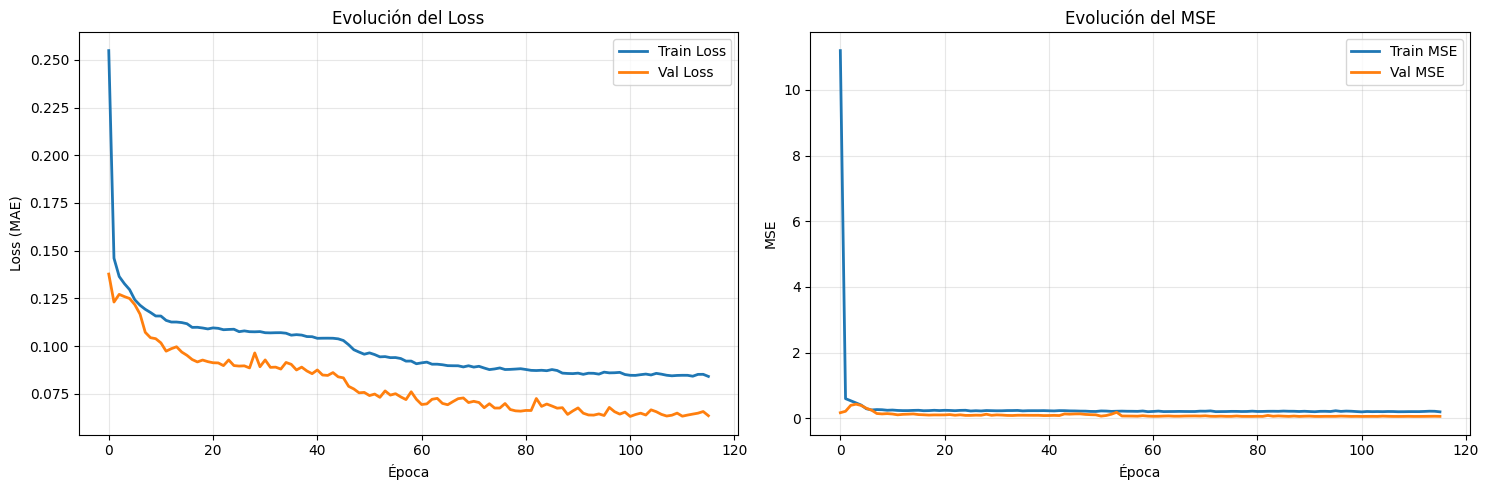

In [7]:
# VISUALIZACION DE CURVAS DE ENTRENAMIENTO

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(historial.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(historial.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss (MAE)')
axes[0].set_title('Evolución del Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MSE
axes[1].plot(historial.history['mse'], label='Train MSE', linewidth=2)
axes[1].plot(historial.history['val_mse'], label='Val MSE', linewidth=2)
axes[1].set_xlabel('Época')
axes[1].set_ylabel('MSE')
axes[1].set_title('Evolución del MSE')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# DETECCION DE ANOMALIAS Y OPTIMIZACION DE UMBRAL

print("\nCalculando errores de reconstrucción...")
X_todos_reconstruido = autoencoder.predict(X_todos_escalado, verbose=0)
error_reconstruccion = np.mean(np.abs(X_todos_escalado - X_todos_reconstruido), axis=1)
datos_trabajo['ERROR_RECONSTRUCCION'] = error_reconstruccion

# Calcular errores por variable
errores_features = np.abs(X_todos_escalado - X_todos_reconstruido)
for i, feat in enumerate(variables_finales):
    datos_trabajo[f'ERROR_{feat}'] = errores_features[:, i]

# Optimizar threshold
print("Optimizando umbral de decisión...")
thresholds = np.percentile(error_reconstruccion, range(85, 100, 1))
mejor_f1 = 0
mejor_threshold = 0
mejor_metricas = {}

for thresh in thresholds:
    predicciones = (error_reconstruccion > thresh).astype(int)
    f1 = f1_score(y_todos, predicciones, zero_division=0)
    
    if f1 > mejor_f1:
        mejor_f1 = f1
        mejor_threshold = thresh
        mejor_metricas = {
            'accuracy': accuracy_score(y_todos, predicciones),
            'precision': precision_score(y_todos, predicciones, zero_division=0),
            'recall': recall_score(y_todos, predicciones, zero_division=0),
            'f1_score': f1
        }

# Clasificar anomalías con mejor umbral
datos_trabajo['ANOMALIA'] = (error_reconstruccion > mejor_threshold).astype(int)

print(f"\n" + "="*80)
print("RESULTADOS DE DETECCIÓN")
print("="*80)
print(f"Umbral óptimo: {mejor_threshold:.4f}")
print(f"Anomalías detectadas: {datos_trabajo['ANOMALIA'].sum():,} ({datos_trabajo['ANOMALIA'].mean()*100:.2f}%)")
print(f"\nMétricas de Clasificación:")
print(f"  Accuracy:  {mejor_metricas['accuracy']:.4f}")
print(f"  Precision: {mejor_metricas['precision']:.4f}")
print(f"  Recall:    {mejor_metricas['recall']:.4f}")
print(f"  F1-Score:  {mejor_metricas['f1_score']:.4f}")

puntaje_auc = roc_auc_score(y_todos, error_reconstruccion)
print(f"  ROC-AUC:   {puntaje_auc:.4f}")

print(f"\nReporte de Clasificación Detallado:")
print(classification_report(y_todos, datos_trabajo['ANOMALIA'], 
                           target_names=['Normal', 'Fraude'], 
                           zero_division=0))


Calculando errores de reconstrucción...
Optimizando umbral de decisión...

RESULTADOS DE DETECCIÓN
Umbral óptimo: 0.0824
Anomalías detectadas: 46,127 (15.00%)

Métricas de Clasificación:
  Accuracy:  0.7994
  Precision: 0.1003
  Recall:    0.1864
  F1-Score:  0.1305
  ROC-AUC:   0.5461

Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

      Normal       0.92      0.85      0.89    282686
      Fraude       0.10      0.19      0.13     24825

    accuracy                           0.80    307511
   macro avg       0.51      0.52      0.51    307511
weighted avg       0.86      0.80      0.83    307511



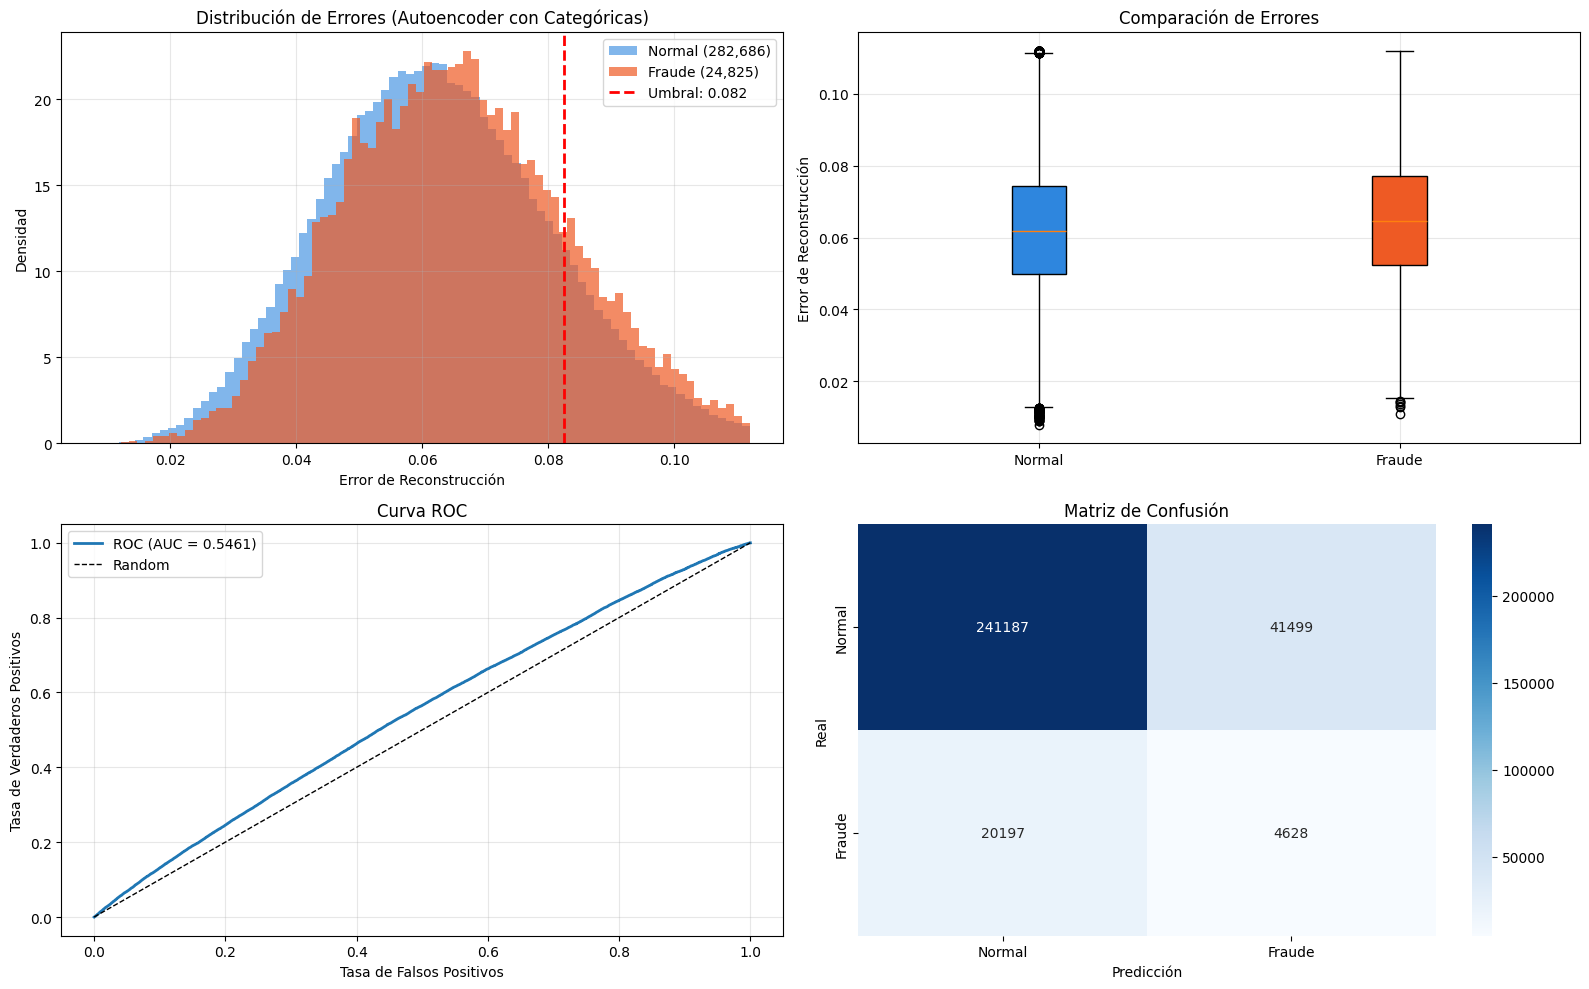

In [9]:
# VISUALIZACION DE DISTRIBUCION DE ERRORES

errores_normales = datos_trabajo[datos_trabajo['TARGET'] == 0]['ERROR_RECONSTRUCCION']
errores_fraude = datos_trabajo[datos_trabajo['TARGET'] == 1]['ERROR_RECONSTRUCCION']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histograma
rango_max = np.percentile(error_reconstruccion, 99)
axes[0, 0].hist(errores_normales[errores_normales < rango_max], bins=80, alpha=0.6, 
                label=f'Normal ({len(errores_normales):,})', color='#2E86DE', density=True)
axes[0, 0].hist(errores_fraude[errores_fraude < rango_max], bins=80, alpha=0.7, 
                label=f'Fraude ({len(errores_fraude):,})', color='#EE5A24', density=True)
axes[0, 0].axvline(mejor_threshold, color='red', linestyle='--', linewidth=2, 
                   label=f'Umbral: {mejor_threshold:.3f}')
axes[0, 0].set_xlabel('Error de Reconstrucción')
axes[0, 0].set_ylabel('Densidad')
axes[0, 0].set_title('Distribución de Errores (Autoencoder con Categóricas)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Boxplot
errores_norm_lim = errores_normales[errores_normales < rango_max]
errores_fraud_lim = errores_fraude[errores_fraude < rango_max]
bp = axes[0, 1].boxplot([errores_norm_lim, errores_fraud_lim], 
                        labels=['Normal', 'Fraude'], patch_artist=True)
bp['boxes'][0].set_facecolor('#2E86DE')
bp['boxes'][1].set_facecolor('#EE5A24')
axes[0, 1].set_ylabel('Error de Reconstrucción')
axes[0, 1].set_title('Comparación de Errores')
axes[0, 1].grid(alpha=0.3)

# Curva ROC
fpr, tpr, _ = roc_curve(y_todos, error_reconstruccion)
axes[1, 0].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {puntaje_auc:.4f})')
axes[1, 0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1, 0].set_xlabel('Tasa de Falsos Positivos')
axes[1, 0].set_ylabel('Tasa de Verdaderos Positivos')
axes[1, 0].set_title('Curva ROC')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Matriz de confusión
cm = confusion_matrix(y_todos, datos_trabajo['ANOMALIA'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1],
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'])
axes[1, 1].set_ylabel('Real')
axes[1, 1].set_xlabel('Predicción')
axes[1, 1].set_title('Matriz de Confusión')

plt.tight_layout()
plt.show()

In [10]:
# ANALISIS DE TOP 10 CASOS MAS SOSPECHOSOS

top_10 = datos_trabajo.nlargest(10, 'ERROR_RECONSTRUCCION').copy()

print("\n" + "="*100)
print("TOP 10 CASOS MÁS SOSPECHOSOS (Con Variables Categóricas)")
print("="*100)

for idx, (i, fila) in enumerate(top_10.iterrows(), 1):
    print(f"\nCASO #{idx} - ID: {int(fila['SK_ID_CURR'])}")
    print(f"Error: {fila['ERROR_RECONSTRUCCION']:.4f} | TARGET: {'FRAUDE' if fila['TARGET']==1 else 'NORMAL'}")
    
    # Datos originales (antes del encoding)
    id_curr = int(fila['SK_ID_CURR'])
    datos_orig = datos[datos['SK_ID_CURR'] == id_curr].iloc[0]
    
    print(f"Perfil Financiero:")
    print(f"  Ingreso: ${fila['AMT_INCOME_TOTAL']:,.0f}")
    print(f"  Crédito: ${fila['AMT_CREDIT']:,.0f}")
    print(f"  Ratio Crédito/Ingreso: {fila['RATIO_CREDITO_INGRESO']:.2f}x")
    
    print(f"Perfil Demográfico:")
    print(f"  Edad: {fila['EDAD']:.0f} años")
    print(f"  Años de empleo: {fila['AÑOS_EMPLEADO']:.1f}")
    print(f"  Género: {datos_orig['CODE_GENDER']}")
    print(f"  Educación: {datos_orig['NAME_EDUCATION_TYPE']}")
    print(f"  Estado civil: {datos_orig['NAME_FAMILY_STATUS']}")
    print(f"  Tipo de ingreso: {datos_orig['NAME_INCOME_TYPE']}")
    print(f"  Vivienda: {datos_orig['NAME_HOUSING_TYPE']}")
    if datos_orig['OCCUPATION_TYPE'] != 'Unknown':
        print(f"  Ocupación: {datos_orig['OCCUPATION_TYPE']}")
    
    # Señales de alerta
    alertas = []
    if fila['SOBREENDEUDAMIENTO'] == 1:
        alertas.append("Sobreendeudamiento extremo")
    if fila['JOVEN_CREDITO_ALTO'] == 1:
        alertas.append("Joven con crédito alto")
    if fila['EMPLEO_NUEVO_CREDITO_ALTO'] == 1:
        alertas.append("Empleo reciente + crédito alto")
    if fila['TOTAL_INCONSISTENCIAS'] > 0:
        alertas.append(f"{int(fila['TOTAL_INCONSISTENCIAS'])} inconsistencias")
    if fila['TIENE_CIRCULO_RIESGOSO'] == 1:
        alertas.append("Círculo social riesgoso")
    if fila['CONSULTAS_EXCESIVAS'] == 1:
        alertas.append("Consultas bureau excesivas")
    if fila['SCORE_ESTABILIDAD'] < 2:
        alertas.append(f"Baja estabilidad ({int(fila['SCORE_ESTABILIDAD'])}/4)")
    
    if alertas:
        print(f"Alertas: {', '.join(alertas)}")
    
    # Top 3 variables más anómalas
    errores_vars = {}
    for var in variables_finales:
        col_error = f'ERROR_{var}'
        if col_error in fila.index:
            errores_vars[var] = fila[col_error]
    
    top_3_errores = sorted(errores_vars.items(), key=lambda x: x[1], reverse=True)[:3]
    
    print("Top 3 Variables Más Anómalas:")
    for j, (nombre_feat, val_error) in enumerate(top_3_errores, 1):
        if nombre_feat in variables_numericas:
            valor_actual = fila[nombre_feat]
            print(f"  {j}. {nombre_feat}: {valor_actual:.4f} (error: {val_error:.4f})")
        else:
            # Variable categórica
            print(f"  {j}. {nombre_feat}: {int(fila[nombre_feat])} (error: {val_error:.4f})")
    
    print("-" * 100)

# Resumen del top 10
print(f"\nRESUMEN TOP 10:")
print(f"Fraudes reales detectados: {int(top_10['TARGET'].sum())}/10")
print(f"Ratio crédito/ingreso promedio: {top_10['RATIO_CREDITO_INGRESO'].mean():.2f}x")
print(f"Con inconsistencias: {(top_10['TOTAL_INCONSISTENCIAS'] > 0).sum()}/10")
print(f"Con círculo riesgoso: {int(top_10['TIENE_CIRCULO_RIESGOSO'].sum())}/10")
print(f"Edad promedio: {top_10['EDAD'].mean():.1f} años")


TOP 10 CASOS MÁS SOSPECHOSOS (Con Variables Categóricas)

CASO #1 - ID: 114967
Error: 14.0772 | TARGET: FRAUDE
Perfil Financiero:
  Ingreso: $117,000,000
  Crédito: $562,491
  Ratio Crédito/Ingreso: 0.00x
Perfil Demográfico:
  Edad: 35 años
  Años de empleo: 2.5
  Género: F
  Educación: Secondary / secondary special
  Estado civil: Married
  Tipo de ingreso: Working
  Vivienda: House / apartment
  Ocupación: Laborers
Alertas: 1 inconsistencias
Top 3 Variables Más Anómalas:
  1. AMT_INCOME_TOTAL: 117000000.0000 (error: 1226.6426)
  2. INGRESO_PER_CAPITA: 29250000.0000 (error: 764.4057)
  3. AÑOS_EMPLEADO: 2.5260 (error: 62.3408)
----------------------------------------------------------------------------------------------------

CASO #2 - ID: 336147
Error: 1.9936 | TARGET: NORMAL
Perfil Financiero:
  Ingreso: $18,000,090
  Crédito: $675,000
  Ratio Crédito/Ingreso: 0.04x
Perfil Demográfico:
  Edad: 43 años
  Años de empleo: 13.6
  Género: M
  Educación: Secondary / secondary special
  

In [11]:
# EXPORTAR METRICAS PARA COMPARACION CON OTROS MODELOS

metricas_finales = {
    'Modelo': 'Autoencoder Denso + Categóricas',
    'Accuracy': mejor_metricas['accuracy'],
    'Precision': mejor_metricas['precision'],
    'Recall': mejor_metricas['recall'],
    'F1-Score': mejor_metricas['f1_score'],
    'ROC-AUC': puntaje_auc
}

df_metricas = pd.DataFrame([metricas_finales])

print("\n" + "="*80)
print("MÉTRICAS FINALES - AUTOENCODER DENSO CON VARIABLES CATEGÓRICAS")
print("="*80)
print(df_metricas.to_string(index=False))
print("\n" + "="*80)

# Resumen ejecutivo
print("\nRESUMEN EJECUTIVO:")
print(f"Variables totales utilizadas: {len(variables_finales)}")
print(f"  - Numéricas: {len(variables_numericas)}")
print(f"  - Categóricas (One-Hot): {len(columnas_categoricas_encoded)}")
print(f"Casos analizados: {len(datos_trabajo):,}")
print(f"Anomalías detectadas: {datos_trabajo['ANOMALIA'].sum():,} ({datos_trabajo['ANOMALIA'].mean()*100:.2f}%)")
print(f"Fraudes reales: {(y_todos == 1).sum():,} ({(y_todos == 1).mean()*100:.2f}%)")
print(f"\nRendimiento del modelo:")
print(f"  ROC-AUC: {puntaje_auc:.4f}")
print(f"  F1-Score: {mejor_metricas['f1_score']:.4f}")
print(f"  Precisión: {mejor_metricas['precision']:.4f}")
print(f"  Recall: {mejor_metricas['recall']:.4f}")

df_metricas


MÉTRICAS FINALES - AUTOENCODER DENSO CON VARIABLES CATEGÓRICAS
                         Modelo  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Autoencoder Denso + Categóricas   0.79937   0.100332 0.186425  0.130454 0.546086


RESUMEN EJECUTIVO:
Variables totales utilizadas: 157
  - Numéricas: 31
  - Categóricas (One-Hot): 126
Casos analizados: 307,511
Anomalías detectadas: 46,127 (15.00%)
Fraudes reales: 24,825 (8.07%)

Rendimiento del modelo:
  ROC-AUC: 0.5461
  F1-Score: 0.1305
  Precisión: 0.1003
  Recall: 0.1864


,Modelo,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Autoencoder Denso + Categóricas,0.79937,0.100332,0.186425,0.130454,0.546086
